In [1]:
import torch
from PIL import Image
import requests
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [37]:
feature_extractor_detc = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model_detc = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

In [41]:
model_cap = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor_cap = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_cap = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cap.to(device)
max_length, num_beams, gen_kwargs = 16, 4, {"max_length": max_length, "num_beams": num_beams}

In [91]:
def load_translation_model(target):
    model_tr = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-{}".format(target.strip()))
    tokenizer_tr = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-{}".format(target.strip()))
    return model_tr, tokenizer_tr

In [124]:
def detect_objects(path):
    image = Image.open(path)
    inputs_detc = feature_extractor_detc(images=image, return_tensors="pt")
    outputs_detc = model_detc(**inputs_detc)
    target_sizes = torch.tensor([image.size[::-1]])
    results = feature_extractor_detc.post_process(outputs_detc, target_sizes=target_sizes)[0]        
    object_present = {}
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if score > 0.9:
            try:
                object_present[model_detc.config.id2label[label.item()]] += 1
            except:
                object_present[model_detc.config.id2label[label.item()]] = 1
                
    return object_present, image

In [125]:
def generate_caption(image_path):
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")

    pixel_values = feature_extractor_cap(images=[i_image], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    output_ids = model_cap.generate(pixel_values, **gen_kwargs)
    preds = tokenizer_cap.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds[0]

In [150]:
def translate(text):
    response = input("Do you want to translate the into other language other than English (y/n)")
    if response:
        
        print("""Please enter your choice of translation:\n 
                 1) de -> German
                 2) fr -> French
                 3) hi -> Hindi\n""")
        
        response = input("Please enter your response (de/fr/hi): ")
        model_tr, tokenizer_tr = load_translation_model(response)
        tokenized_text = tokenizer_tr([text], return_tensors='pt')
        translation = model_tr.generate(**tokenized_text, max_length = 500)
        translated_text = tokenizer_tr.batch_decode(translation, skip_special_tokens=True)[0]
        print("\n\n")
        return translated_text
    else:
        print("No Response")

In [153]:
def make_pipeline(image_path):
    ## Object Detection
    obj_det, image = detect_objects(image_path)
    display(image, )
    print("\n----------\nObjects Detected are as follows: \n{}\n----------\n".format(str(obj_det)))
    
    ## Image Captioning
    caption_generated = generate_caption(image_path)
    print("\n----------\nGenerated Caption: \n{}\n----------\n".format(caption_generated))
    
    ## Caption Translation
    translated_text = translate(caption_generated)
    print("\n----------\nTranslated text: \n{}\n----------\n".format(translated_text))

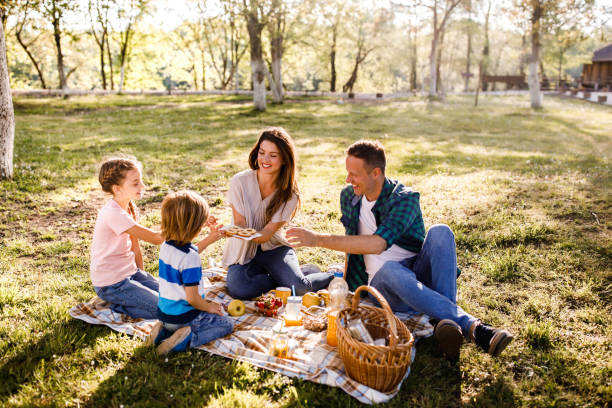


----------
Objects Detected are as follows: 
{'cup': 2, 'bench': 1, 'person': 4, 'bottle': 1}
----------


----------
Generated Caption: 
a family sitting around a picnic table with a cake
----------



Do you want to translate the into other language other than English (y/n) y


Please enter your choice of translation:
 
                 1) de -> German
                 2) fr -> French
                 3) hi -> Hindi



Please enter your response (de/fr/hi):  de






----------
Translated text: 
eine Familie, die um einen Picknicktisch mit einem Kuchen sitzt
----------



In [154]:
path = "sample_images//sample_image3.jpeg"
make_pipeline(path)

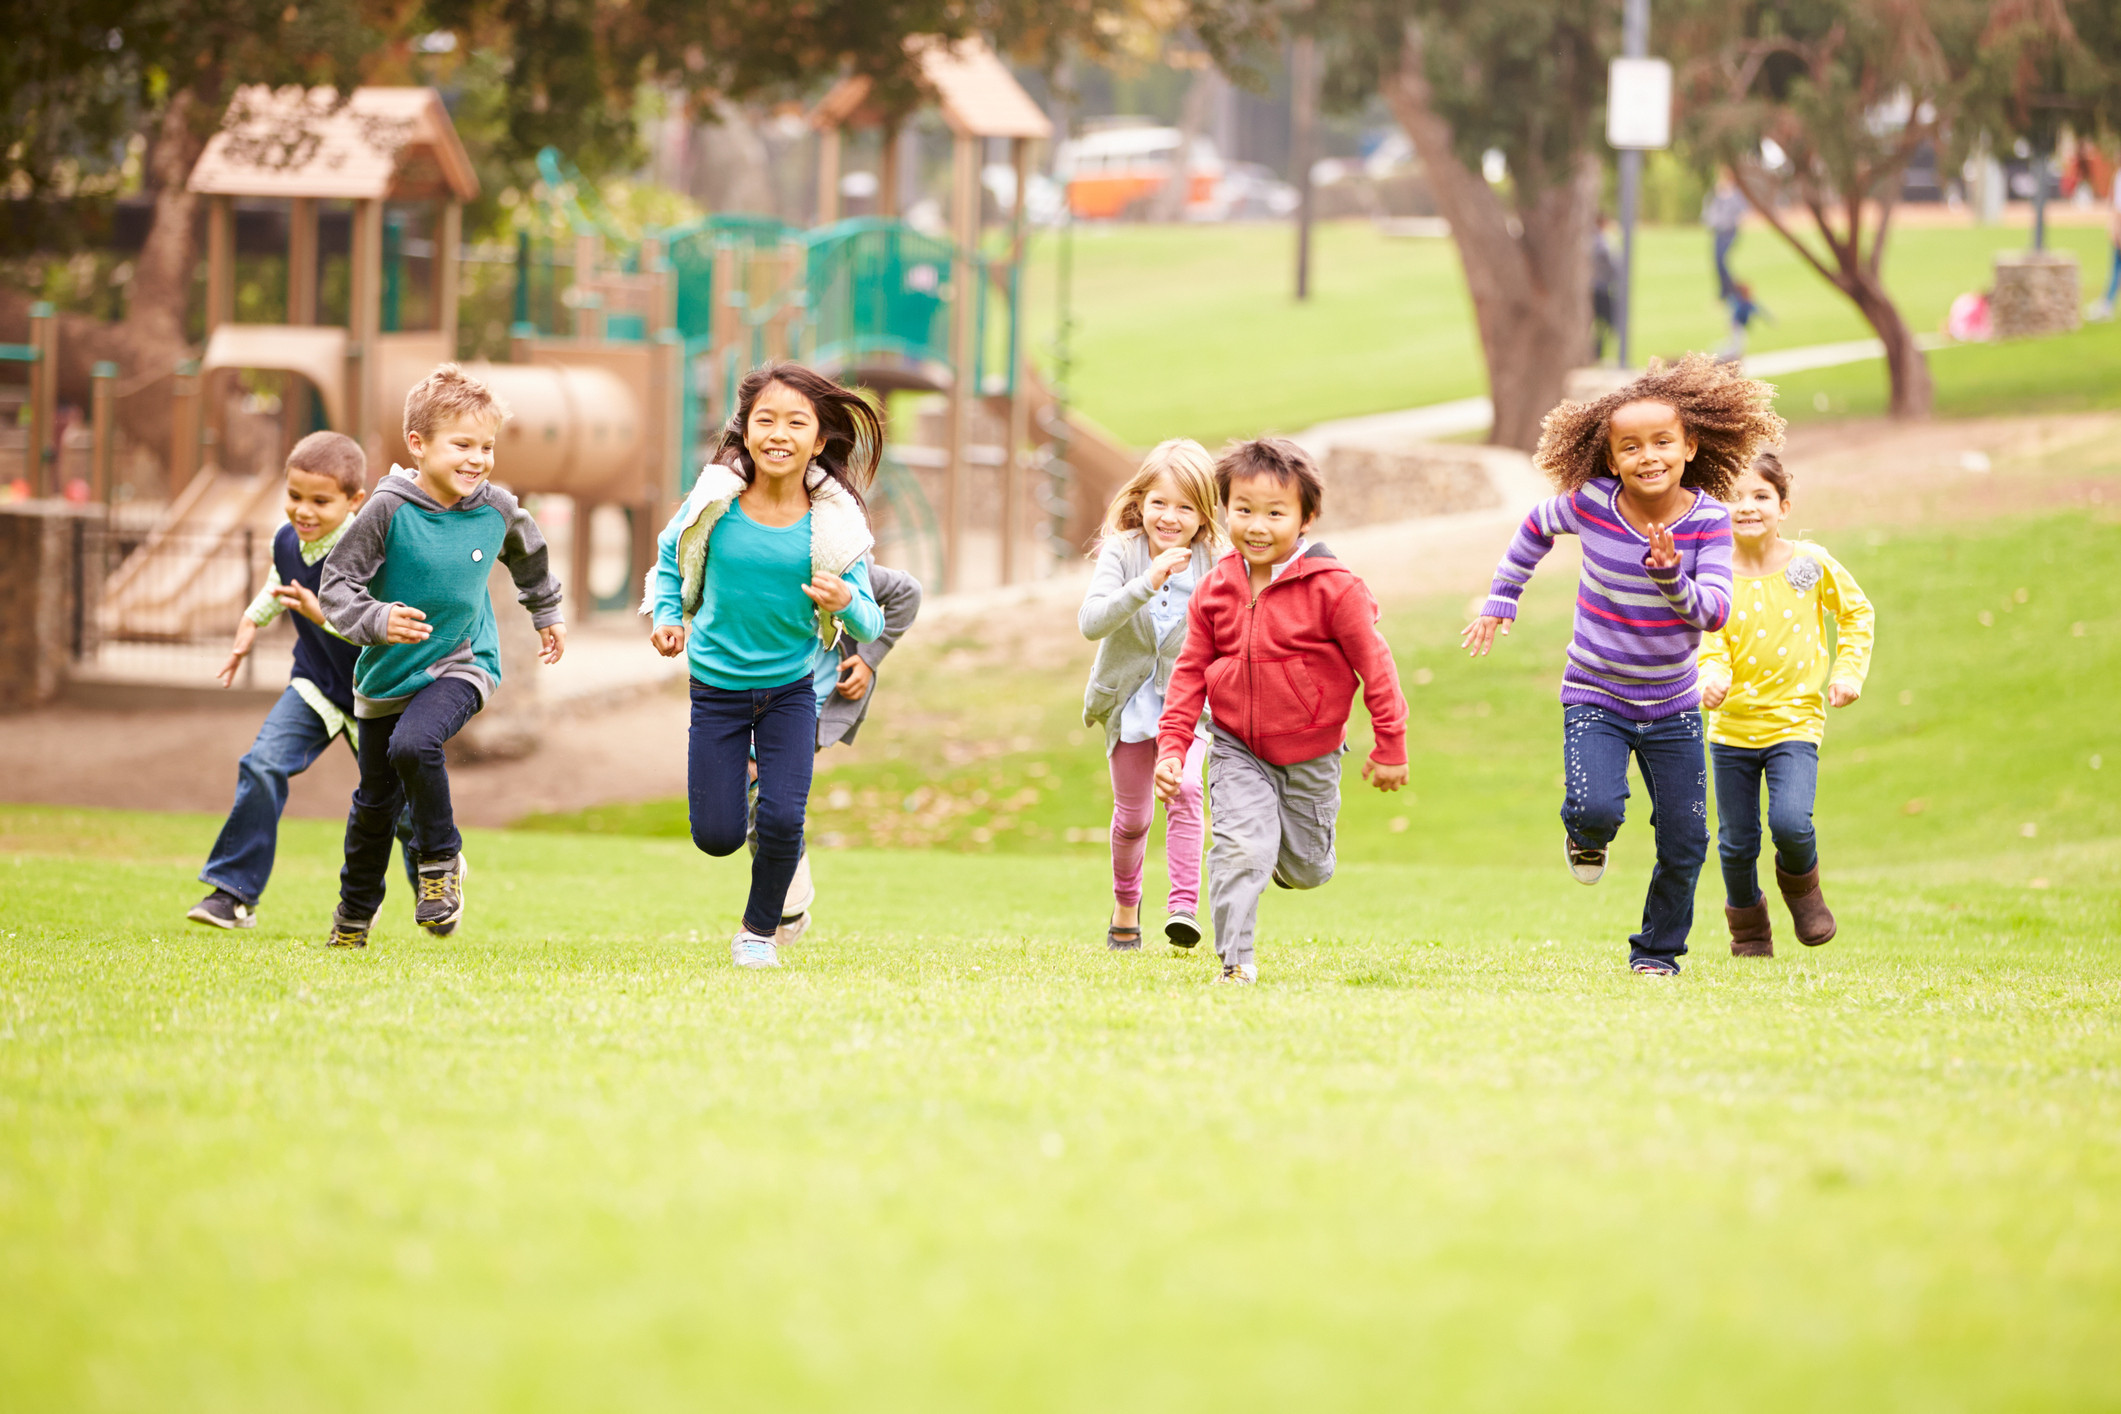


----------
Objects Detected are as follows: 
{'person': 8}
----------


----------
Generated Caption: 
young children playing in a grassy field
----------



Do you want to translate the into other language other than English (y/n) y


Please enter your choice of translation:
 
                 1) de -> German
                 2) fr -> French
                 3) hi -> Hindi



Please enter your response (de/fr/hi):  fr






----------
Translated text: 
jeunes enfants jouant dans un champ herbeux
----------



In [158]:
path = "sample_images//sample_image1.jpeg"
make_pipeline(path)

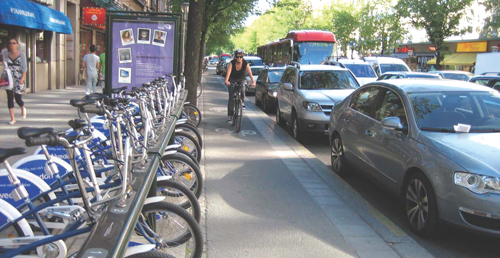


----------
Objects Detected are as follows: 
{'car': 10, 'bicycle': 6, 'person': 4, 'truck': 1, 'handbag': 1, 'bus': 1}
----------


----------
Generated Caption: 
a row of parked cars on a city street
----------



Do you want to translate the into other language other than English (y/n) y


Please enter your choice of translation:
 
                 1) de -> German
                 2) fr -> French
                 3) hi -> Hindi



Please enter your response (de/fr/hi):  hi






----------
Translated text: 
शहर की सड़क पर खड़ी कारों की एक कतार
----------



In [159]:
path = "sample_images//sample_image5.jpeg"
make_pipeline(path)